In [17]:
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns #libreria para visualização de gráficos
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Charge and Exploration of the Dataset

In [18]:
def load_data(file_path):
    """
    Loads the data from a CSV file and performs an initial exploration.
    
    Args:
    file_path (str): Path to the CSV file containing the data.
    
    Returns:
    pd.DataFrame: DataFrame with the loaded data.
    """
    # Detect file encoding
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        encoding = result['encoding']

    print(f"Detected file encoding: {encoding}")

    try:
        # Try to read the file with the detected encoding
        data = pd.read_csv(file_path, encoding=encoding)
    except UnicodeDecodeError:
        print("Error with detected encoding. Trying 'latin-1' encoding...")
        try:
            # If that fails, try 'latin-1' encoding
            data = pd.read_csv(file_path, encoding='latin-1')
        except Exception as e:
            print(f"Error loading the file: {e}")
            return None

    print("Dataset dimensions:", data.shape)
    print("\nFirst 5 rows of the dataset:")
    print(data.head())
    print("\nDataset information:")
    print(data.info())
    print("\nDescriptive statistics:")
    print(data.describe())
    return data

## Reading genome.csv

In [19]:
data = load_data('.\csv\genomeTrainDisease.csv')

if data is not None:
    # Continúa con el procesamiento de los datos
    pass
else:
    print("No se pudieron cargar los datos. Por favor, verifica el archivo y su codificación.")

Detected file encoding: ISO-8859-1


C:\Users\JERON\AppData\Local\Temp\ipykernel_29752\564550034.py:21: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding=encoding)


Dataset dimensions: (966977, 7)

First 5 rows of the dataset:
         rsid chromosome  position genotype  magnitude reputation summary
0   rs4477212          1     72017       AA        NaN        NaN     NaN
1   rs3094315          1    742429       AA        NaN        NaN     NaN
2   rs3131972          1    742584       GG        NaN        NaN     NaN
3  rs12124819          1    766409       AA        NaN        NaN     NaN
4  rs11240777          1    788822       AG        NaN        NaN     NaN

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966977 entries, 0 to 966976
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   rsid        966977 non-null  object 
 1   chromosome  966977 non-null  object 
 2   position    966977 non-null  int64  
 3   genotype    966977 non-null  object 
 4   magnitude   1392 non-null    float64
 5   reputation  934 non-null     object 
 6   summary     982 non-n

# Data Preprocesing
## Cleaning the data

In [20]:
def clean_data(data):
    """
    Cleans the data by handling missing values and verifying the distribution.
    
    Args:
    data (pd.DataFrame): Original DataFrame.
    
    Returns:
    pd.DataFrame: Cleaned DataFrame.
    """
    
    print("Missing values for columns:")
    print(data.isnull().sum())

    # Handle missing values for numeric columns
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_columns) > 0:
        numeric_imputer = SimpleImputer(strategy='mean')
        data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])

    # Handle missing values for categorical columns (including 'genotype')
    categorical_columns = data.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

    print("\nDistribution of genotypes:")
    print(data['genotype'].value_counts(normalize=True))

    # Check for any remaining missing values
    print("\nRemaining missing values:")
    print(data.isnull().sum())

    return data


data_clean = clean_data(data)

Missing values for columns:
rsid               0
chromosome         0
position           0
genotype           0
magnitude     965585
reputation    966043
summary       965995
dtype: int64

Distribution of genotypes:
genotype
CC    0.180192
GG    0.179433
TT    0.152389
AA    0.152314
CT    0.119876
AG    0.119552
GT    0.027953
AC    0.027739
C     0.008156
G     0.008005
A     0.007474
T     0.007386
--    0.006541
CG    0.001208
II    0.000754
AT    0.000654
DD    0.000184
I     0.000123
D     0.000048
DI    0.000019
Name: proportion, dtype: float64

Remaining missing values:
rsid          0
chromosome    0
position      0
genotype      0
magnitude     0
reputation    0
summary       0
dtype: int64


## Processing data

In [21]:
def preprocess_data(data):
    """
    Realiza el preprocesamiento de los datos, incluyendo codificación one-hot y escalado.
    
    Args:
    data (pd.DataFrame): DataFrame limpio.
    
    Returns:
    tuple: X_processed (features procesadas), preprocessor (ColumnTransformer)
    """
    print("Iniciando preprocesamiento...")
    print("Columnas en el DataFrame:", data.columns)
    print("Tipos de datos:")
    print(data.dtypes)
    
    # Crear preprocesador
    numeric_features = ['chromosome', 'position']
    categorical_features = ['genotype']
    
    print("Características numéricas:", numeric_features)
    print("Características categóricas:", categorical_features)
    
    # Convertir 'chromosome' y 'position' a tipo numérico si no lo son
    data['chromosome'] = pd.to_numeric(data['chromosome'], errors='coerce')
    data['position'] = pd.to_numeric(data['position'], errors='coerce')
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    print("Aplicando preprocesamiento...")
    # Ajustar y transformar
    try:
        X_processed = preprocessor.fit_transform(data)
        print("Preprocesamiento completado con éxito.")
    except Exception as e:
        print("Error durante el preprocesamiento:")
        print(str(e))
        raise
    
    print("Obteniendo nombres de características...")
    # Obtener nombres de características después del preprocesamiento
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    feature_names = (numeric_features + 
                     onehot_encoder.get_feature_names_out(categorical_features).tolist())
    
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
    
    print("Dimensiones de X después del preprocesamiento:", X_processed_df.shape)
    print("\nPrimeras 5 filas de X preprocesado:")
    print(X_processed_df.head())
    
    return X_processed_df, preprocessor

# Aplicar
try:
    X_processed, preprocessor = preprocess_data(data_clean)
    print("Preprocesamiento completado exitosamente.")
except Exception as e:
    print("Error al aplicar el preprocesamiento:")
    print(str(e))

Iniciando preprocesamiento...
Columnas en el DataFrame: Index(['rsid', 'chromosome', 'position', 'genotype', 'magnitude', 'reputation',
       'summary'],
      dtype='object')
Tipos de datos:
rsid           object
chromosome     object
position      float64
genotype       object
magnitude     float64
reputation     object
summary        object
dtype: object
Características numéricas: ['chromosome', 'position']
Características categóricas: ['genotype']
Aplicando preprocesamiento...
Preprocesamiento completado con éxito.
Obteniendo nombres de características...
Dimensiones de X después del preprocesamiento: (966977, 21)

Primeras 5 filas de X preprocesado:
   chromosome  position  genotype_A  genotype_AA  genotype_AC  genotype_AG  \
0   -1.362345 -1.358799         0.0          1.0          0.0          0.0   
1   -1.362345 -1.346914         0.0          1.0          0.0          0.0   
2   -1.362345 -1.346912         0.0          0.0          0.0          0.0   
3   -1.362345 -1.346489 

# Vizualice data cleaning

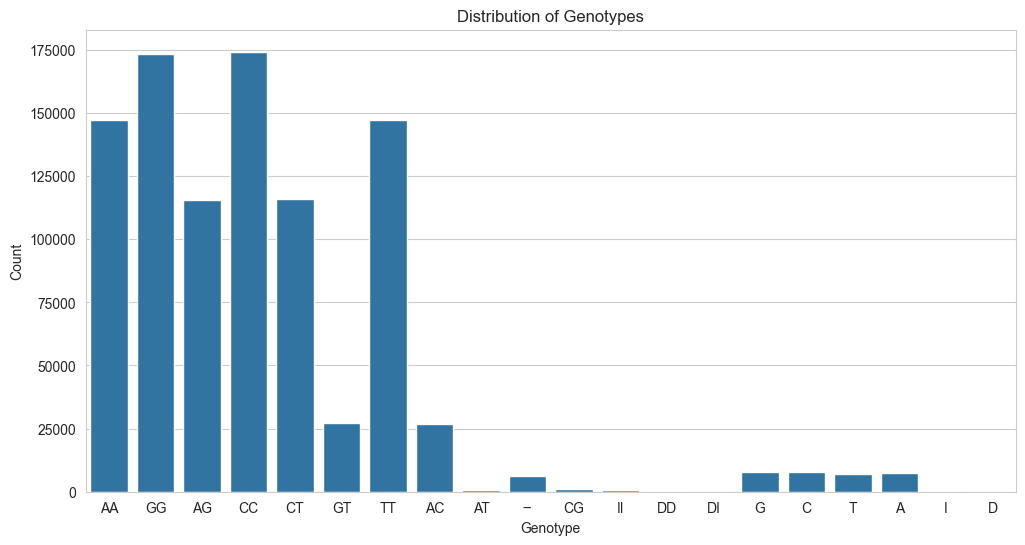

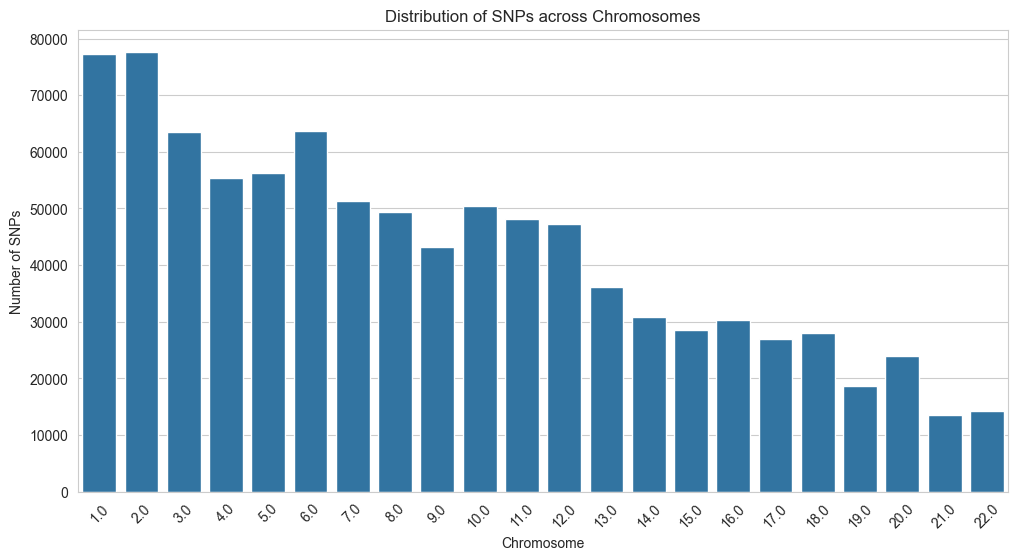

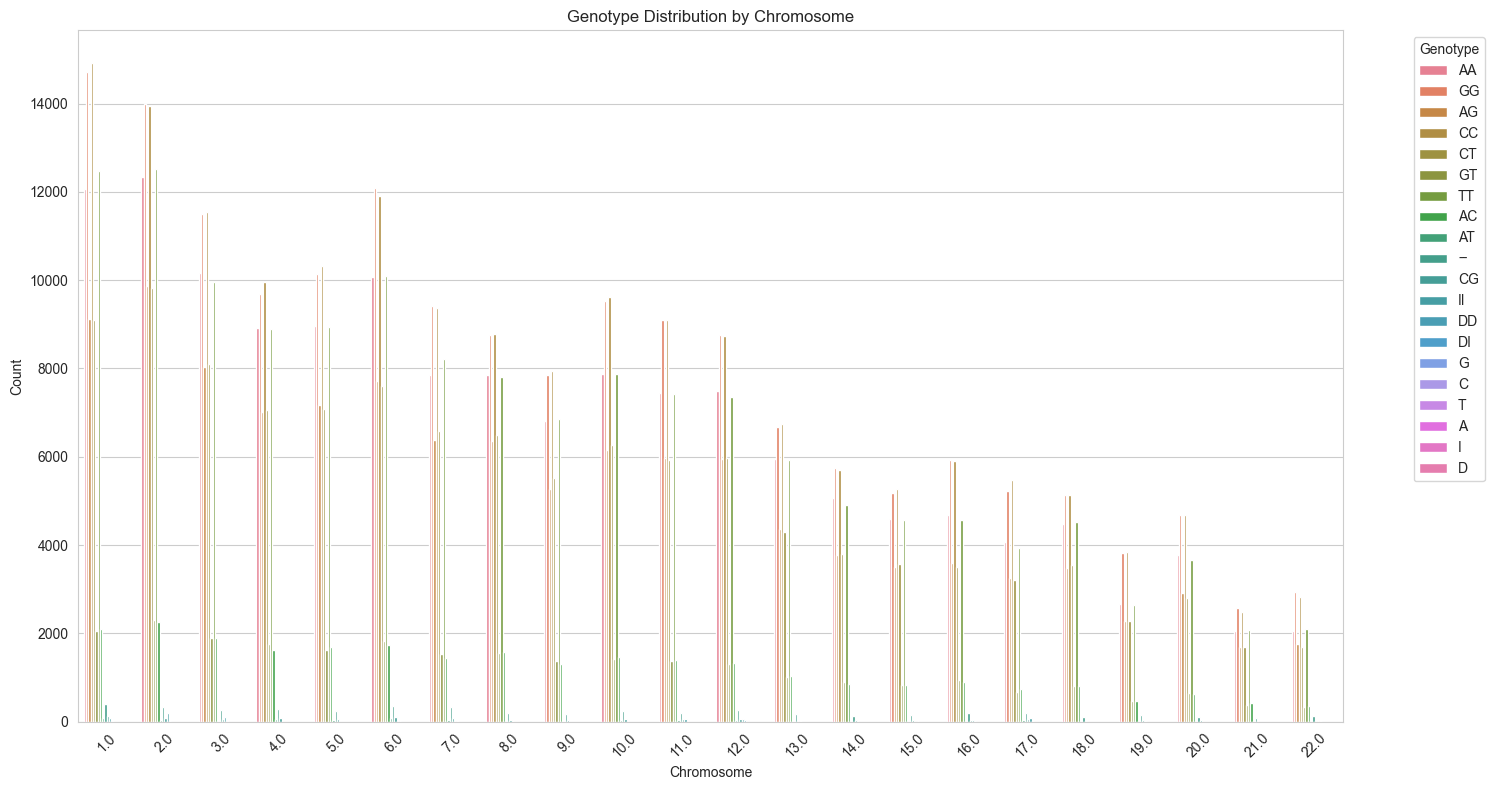

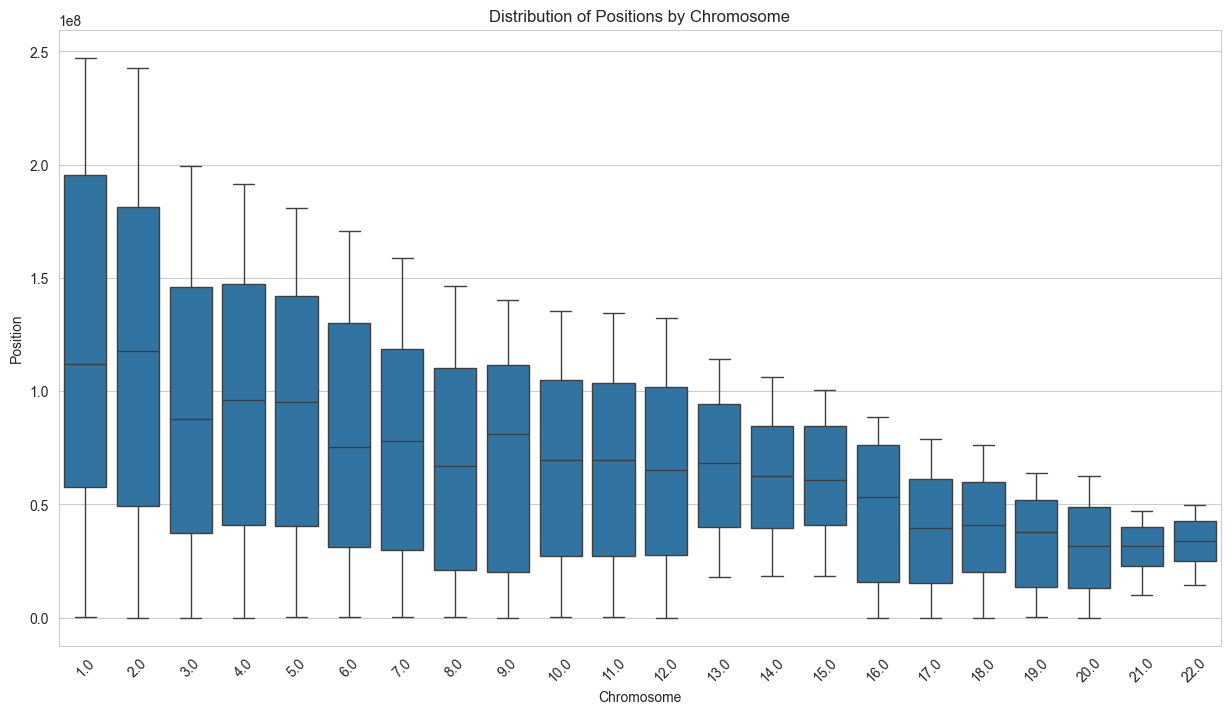

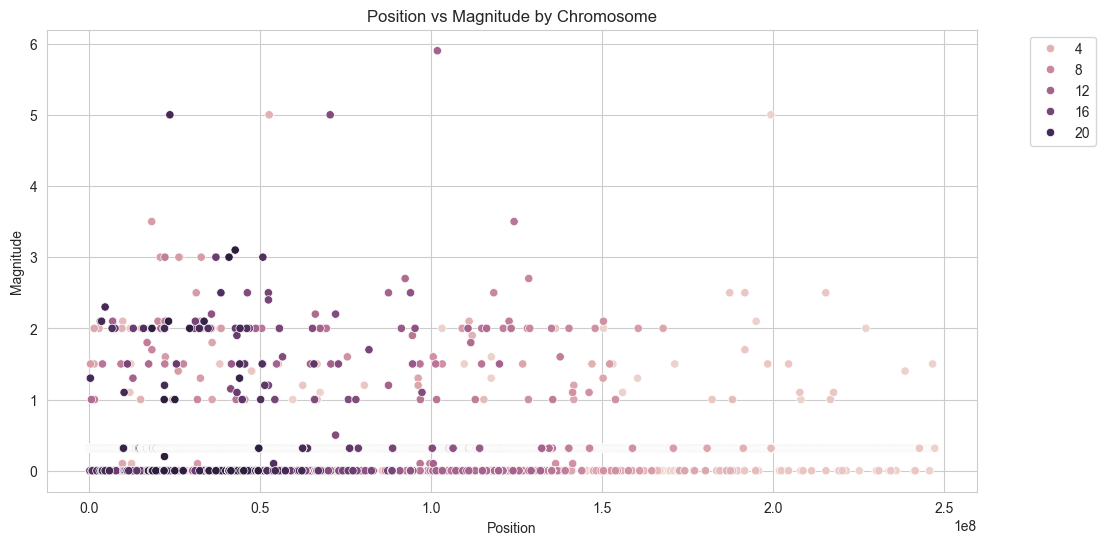

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data(data):
    """
    Creates visualizations to explore the genomic data.
    
    Args:
    data (pd.DataFrame): DataFrame with columns: rsid, chromosome, position, genotype, magnitude, reputation, summary
    """
    
    # Set the style for better-looking plots
    sns.set_style("whitegrid")
    
    # 1. Distribution of Genotypes
    plt.figure(figsize=(12, 6))
    sns.countplot(x='genotype', data=data)
    plt.title('Distribution of Genotypes')
    plt.xlabel('Genotype')
    plt.ylabel('Count')
    plt.show()
    
    # 2. Distribution of Chromosomes
    plt.figure(figsize=(12, 6))
    chromosome_counts = data['chromosome'].value_counts().sort_index()
    sns.barplot(x=chromosome_counts.index, y=chromosome_counts.values)
    plt.title('Distribution of SNPs across Chromosomes')
    plt.xlabel('Chromosome')
    plt.ylabel('Number of SNPs')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Genotype Distribution by Chromosome
    plt.figure(figsize=(15, 8))
    sns.countplot(x='chromosome', hue='genotype', data=data)
    plt.title('Genotype Distribution by Chromosome')
    plt.xlabel('Chromosome')
    plt.ylabel('Count')
    plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Position Distribution by Chromosome
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='chromosome', y='position', data=data)
    plt.title('Distribution of Positions by Chromosome')
    plt.xlabel('Chromosome')
    plt.ylabel('Position')
    plt.xticks(rotation=45)
    plt.show()
    
    # 5. Scatter plot of Position vs Magnitude (if available)
    if 'magnitude' in data.columns and data['magnitude'].notna().any():
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=data, x='position', y='magnitude', hue='chromosome')
        plt.title('Position vs Magnitude by Chromosome')
        plt.xlabel('Position')
        plt.ylabel('Magnitude')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

visualize_data(data_clean)

# Correlation Analisis of numeric features
## Importance of Correlation Analysis

El análisis de correlación es crucial en el preprocesamiento de datos y el análisis exploratorio de datos (AED). Ayuda a:

1. **Identificar relaciones**: Comprender la relación entre las características numéricas puede ayudar a mejorar el rendimiento del modelo al resaltar qué características están correlacionadas positiva o negativamente.
2. 2. **Selección de características**: Las características muy correlacionadas pueden proporcionar información redundante. La eliminación de tales características puede reducir la complejidad del modelo sin perder mucha información.
3. **Detección de multicolinealidad**: En los modelos de regresión, la multicolinealidad (cuando dos o más predictores están altamente correlacionados) puede hacer que las estimaciones de los parámetros sean inestables e inflar los errores estándar. La detección temprana de la multicolinealidad permite realizar los ajustes oportunos.

## Performing Correlation Analysis
Para realizar un análisis de correlación entre características numéricas, siga estos pasos:

1. **Seleccionar características numéricas**: En este caso, seleccionamos 'cromosoma' y 'posición' del conjunto de datos.
 2. **Calcular la matriz de correlación**: Utilizar el método `corr()` proporcionado por pandas para calcular la matriz de correlaciones, que muestra los coeficientes de correlación entre pares de características.
3. **Visualizar Correlación**: Se genera un mapa de calor utilizando la función `heatmap()` de seaborn. Esta representación visual ayuda a identificar rápidamente los patrones de correlación y la fuerza de las relaciones.

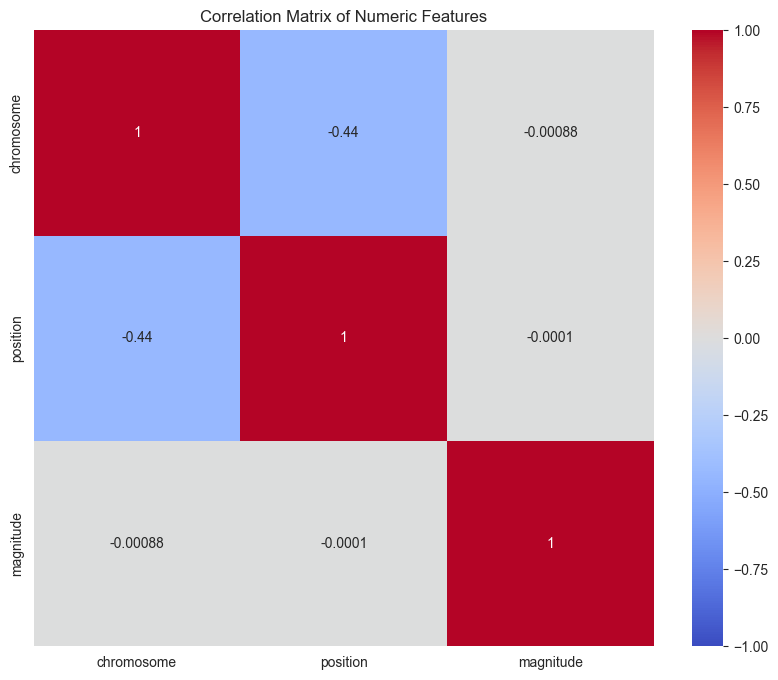

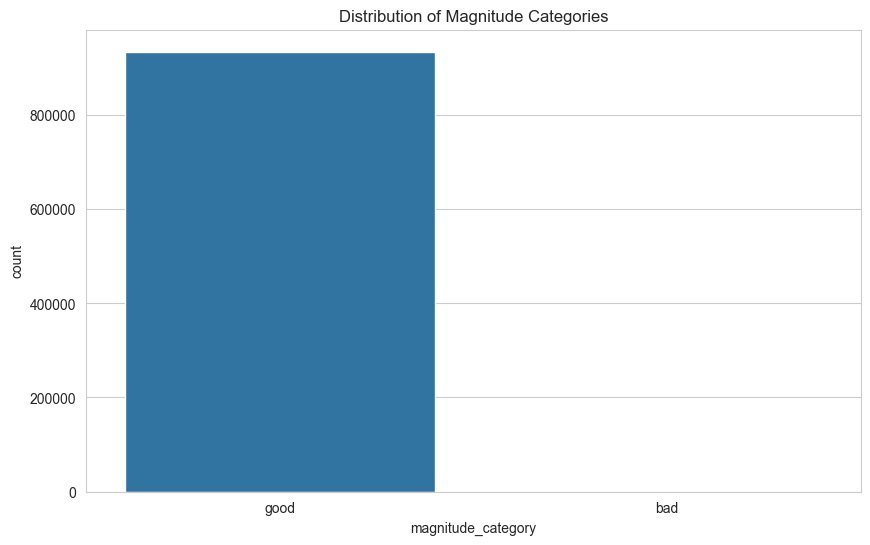

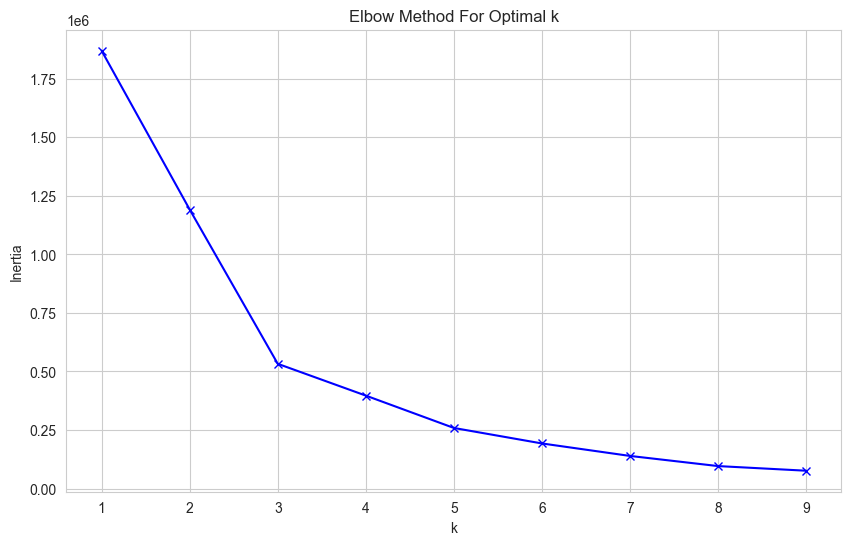

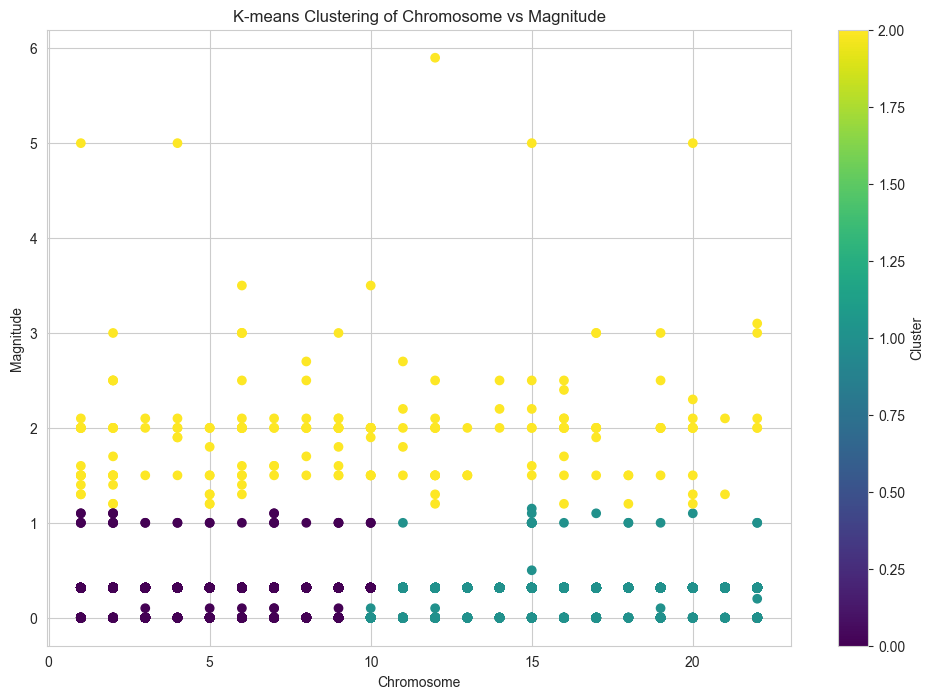


Cluster Statistics:
        magnitude               chromosome        
             mean   std   count       mean nunique
Cluster                                           
0            0.32  0.01  587812       5.03      10
1            0.32  0.01  346666      15.30      13
2            2.01  0.69     192       9.86      22


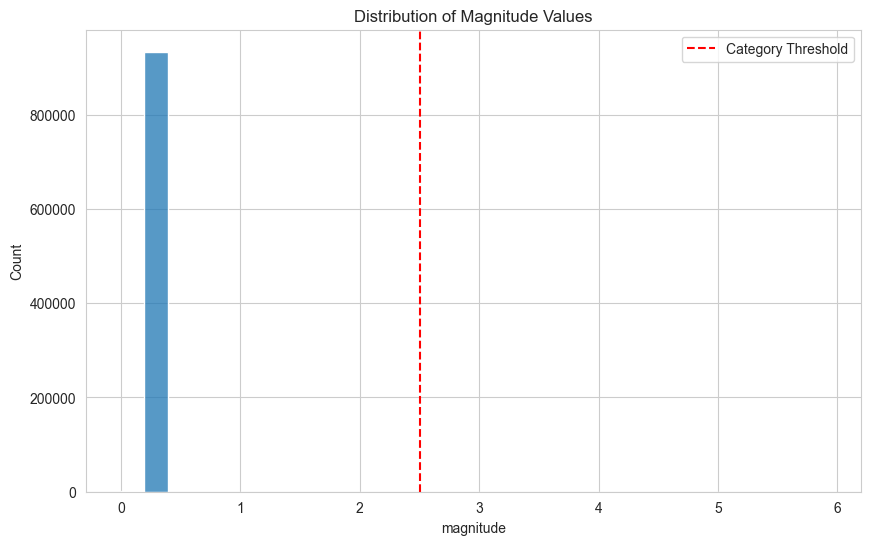


Summary of clean data:
Total rows processed: 966977
Rows with valid data: 934670
Rows removed due to missing/invalid data: 32307

Magnitude statistics:
count    934670.000
mean          0.316
std           0.029
min           0.000
25%           0.316
50%           0.316
75%           0.316
max           5.900
Name: magnitude, dtype: float64


In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def analyze_correlation(data):
    """
    Performs a correlation analysis among numeric features and clustering analysis based on magnitude.
    
    Args:
    data (pd.DataFrame): DataFrame with columns including chromosome, position, magnitude
    """
    # Create a clean copy of the data
    clean_data = data.copy()
    
    # Convert chromosome to numeric, replacing non-numeric values with NaN
    clean_data['chromosome'] = pd.to_numeric(clean_data['chromosome'], errors='coerce')
    
    # Convert magnitude to numeric, replacing non-numeric values with NaN
    clean_data['magnitude'] = pd.to_numeric(clean_data['magnitude'], errors='coerce')
    
    # Remove rows where either chromosome or magnitude is NaN, infinite, or undefined
    clean_data = clean_data.replace([np.inf, -np.inf], np.nan)
    clean_data = clean_data.dropna(subset=['chromosome', 'magnitude'])
    
    if len(clean_data) == 0:
        print("No hay datos válidos después de la limpieza")
        return
        
    # Create magnitude category (solo para valores válidos)
    clean_data['magnitude_category'] = clean_data['magnitude'].apply(
        lambda x: 'good' if 0 <= x <= 2.5 else 'bad' if x > 2.5 else 'undefined'
    )
    
    # Traditional correlation analysis with only numeric columns
    numeric_features = clean_data[['chromosome', 'position', 'magnitude']].copy()
    corr_matrix = numeric_features.corr()
    
    try:
        # Correlation Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('Correlation Matrix of Numeric Features')
        plt.show()

        # Distribution of categories
        plt.figure(figsize=(10, 6))
        valid_categories = clean_data[clean_data['magnitude_category'].isin(['good', 'bad'])]
        sns.countplot(data=valid_categories, x='magnitude_category')
        plt.title('Distribution of Magnitude Categories')
        plt.show()

        # Prepare data for k-means
        X = clean_data[['chromosome', 'magnitude']].copy()
        
        # Additional verification for any remaining NaN values
        X = X.dropna()
        
        if len(X) < 3:
            print("No hay suficientes datos válidos para clustering")
            return
            
        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Determine optimal number of clusters
        max_k = min(10, len(X))
        if max_k > 1:
            inertias = []
            K = range(1, max_k)
            for k in K:
                kmeans = KMeans(n_clusters=k, random_state=42)
                kmeans.fit(X_scaled)
                inertias.append(kmeans.inertia_)
            
            # Plot elbow curve
            plt.figure(figsize=(10, 6))
            plt.plot(K, inertias, 'bx-')
            plt.xlabel('k')
            plt.ylabel('Inertia')
            plt.title('Elbow Method For Optimal k')
            plt.show()
            
            # Perform clustering
            optimal_k = min(3, len(X)-1)
            kmeans = KMeans(n_clusters=optimal_k, random_state=42)
            X['Cluster'] = kmeans.fit_predict(X_scaled)
            
            # Visualize clusters
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(X['chromosome'], 
                                X['magnitude'],
                                c=X['Cluster'], 
                                cmap='viridis')
            plt.xlabel('Chromosome')
            plt.ylabel('Magnitude')
            plt.title('K-means Clustering of Chromosome vs Magnitude')
            plt.colorbar(scatter, label='Cluster')
            plt.show()
            
            # Print statistics
            print("\nCluster Statistics:")
            cluster_stats = X.groupby('Cluster').agg({
                'magnitude': ['mean', 'std', 'count'],
                'chromosome': ['mean', 'nunique']
            }).round(2)
            print(cluster_stats)

        # Additional visualization: Magnitude distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(data=X, x='magnitude', bins=30)
        plt.title('Distribution of Magnitude Values')
        plt.axvline(x=2.5, color='r', linestyle='--', label='Category Threshold')
        plt.legend()
        plt.show()

        # Print summary statistics
        print("\nSummary of clean data:")
        print(f"Total rows processed: {len(data)}")
        print(f"Rows with valid data: {len(X)}")
        print(f"Rows removed due to missing/invalid data: {len(data) - len(X)}")
        print("\nMagnitude statistics:")
        print(X['magnitude'].describe().round(3))

    except Exception as e:
        print(f"Se produjo un error durante el análisis: {str(e)}")
        print("Datos disponibles para diagnóstico:")
        print(f"Número de filas en clean_data: {len(clean_data)}")
        print(f"Columnas disponibles: {clean_data.columns.tolist()}")
        print("Muestra de los primeros registros válidos:")
        print(clean_data.head())
        print("\nResumen estadístico:")
        print(clean_data.describe())

analyze_correlation(data_clean)

- Paso 1**: Extrae datos numéricos de las columnas 'cromosoma' y 'posición'.
- Paso 2**: Calcula la matriz de correlaciones utilizando el método `corr()` de pandas.
- Paso 3**: Traza la matriz de correlación usando `heatmap()` de seaborn, donde:
  - `annot=True` muestra los coeficientes de correlación.
  - `cmap='coolwarm'` especifica el mapa de colores.
  - vmin=-1` y `vmax=1` establecen el rango de la escala de color.
  - `center=0` asegura que el mapa de color está centrado alrededor de cero.

facilitamos de esta forma la interpretación de los resultados.

# SNPs distribution by Chromosome

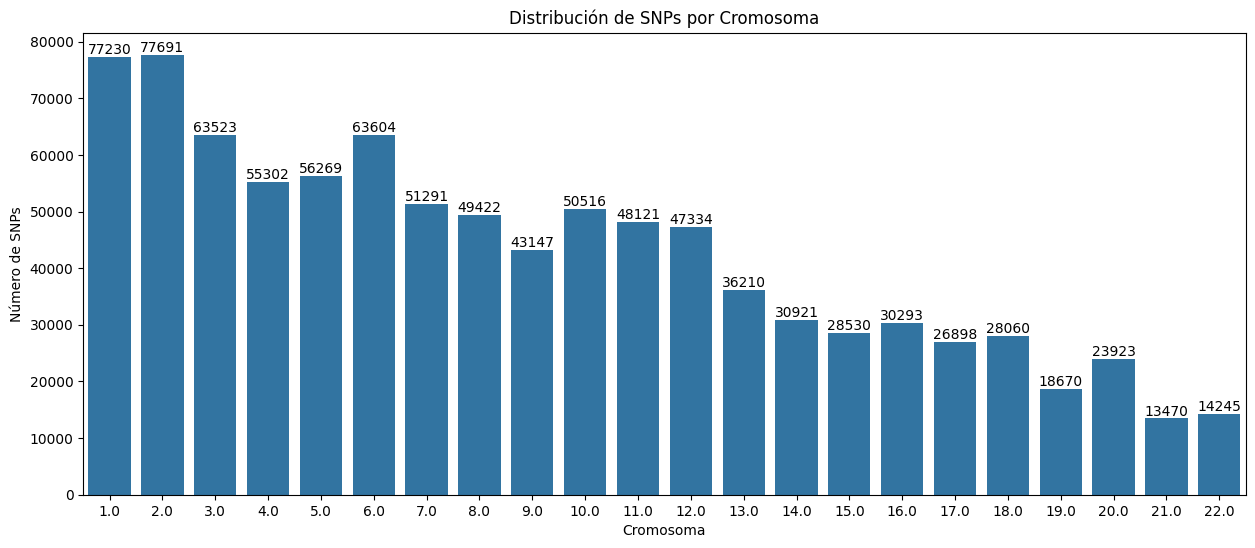

<Figure size 1500x600 with 0 Axes>

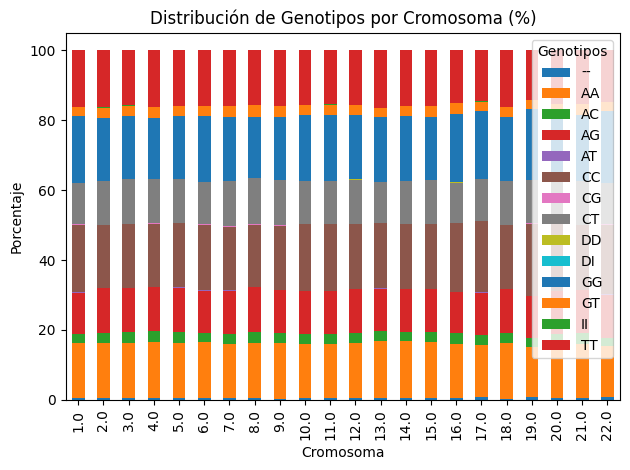


Resumen estadístico por cromosoma:
    Cromosoma  Número de SNPs  Posición Mínima  Posición Máxima  \
0         1.0           77230          72017.0      247185615.0   
1         2.0           77691           8674.0      242697433.0   
2         3.0           63523          36495.0      199322659.0   
3         4.0           55302          61566.0      191200760.0   
4         5.0           56269          80564.0      180629495.0   
5         6.0           63604         100815.0      170761395.0   
6         7.0           51291         140018.0      158812247.0   
7         8.0           49422         154984.0      146264218.0   
8         9.0           43147          36587.0      140208462.0   
9        10.0           50516          88087.0      135358259.0   
10       11.0           48121         188510.0      134445626.0   
11       12.0           47334          61880.0      132287718.0   
12       13.0           36210       17956717.0      114121631.0   
13       14.0           30

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_snp_distribution(data):
    """
    Analyzes the distribution of SNPs across chromosomes and their characteristics.
    
    Args:
    data (pd.DataFrame): DataFrame with columns: rsid, chromosome, position, genotype, magnitude, reputation, summary
    
    Returns:
    pd.DataFrame: Summary statistics by chromosome
    """
    # Use a simple style
    plt.style.use('default')
    
    # 1. SNP Distribution Plot
    snp_counts = data['chromosome'].value_counts().sort_index()
    
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=snp_counts.index, y=snp_counts.values)
    plt.title('Distribución de SNPs por Cromosoma')
    plt.xlabel('Cromosoma')
    plt.ylabel('Número de SNPs')
    plt.xticks(rotation=0)
    
    # Add value labels on top of each bar
    for i, v in enumerate(snp_counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    plt.show()

    # 2. Genotype Distribution by Chromosome
    plt.figure(figsize=(15, 6))
    genotype_dist = pd.crosstab(data['chromosome'], data['genotype'], normalize='index') * 100
    genotype_dist.plot(kind='bar', stacked=True)
    plt.title('Distribución de Genotipos por Cromosoma (%)')
    plt.xlabel('Cromosoma')
    plt.ylabel('Porcentaje')
    plt.legend(title='Genotipos')
    plt.tight_layout()
    plt.show()

    # 3. Generate Summary Statistics
    summary = summarize_by_chromosome(data)
    return summary

def summarize_by_chromosome(data):
    """
    Generates a comprehensive summary of SNPs by chromosome
    
    Args:
    data (pd.DataFrame): DataFrame with genomic data
    
    Returns:
    pd.DataFrame: Detailed summary statistics by chromosome
    """
    # Basic position statistics
    summary = data.groupby('chromosome').agg({
        'position': ['count', 'min', 'max', 'mean', 'median', 'std'],
        'genotype': lambda x: x.value_counts().index[0]  # Most common genotype
    }).round(2)
    
    # Calculate density (SNPs per million base pairs)
    summary['density'] = (summary['position']['count'] / 
                         ((summary['position']['max'] - summary['position']['min']) / 1_000_000)).round(2)
    
    # Flatten column names and rename
    summary.columns = [
        'Número de SNPs',
        'Posición Mínima',
        'Posición Máxima',
        'Posición Media',
        'Posición Mediana',
        'Desviación Estándar',
        'Genotipo más común',
        'Densidad (SNPs/Mb)'
    ]
    
    # Reset index and rename chromosome column
    summary = summary.reset_index().rename(columns={'chromosome': 'Cromosoma'})
    
    # Add spacing for better printing
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    
    return summary

summary = analyze_snp_distribution(data_clean)
print("\nResumen estadístico por cromosoma:")
print(summary)

# Save Preprocessed Data

In [31]:
import json
from datetime import datetime
import os

def save_processed_data(data, output_directory='./processed_data'):
    """
    Saves the preprocessed data and generates a comprehensive analysis report.
    
    Args:
    data (pd.DataFrame): DataFrame with preprocessed data.
    output_directory (str): Directory where the files will be saved.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Generate timestamp for file names
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Save processed data
    data_filename = os.path.join(output_directory, f'processed_genetic_data_{timestamp}.csv')
    data.to_csv(data_filename, index=False)
    print(f"\nProcesamiento completado. Datos guardados en: {data_filename}")
    
    # 2. Generate and save analysis summary
    summary_filename = os.path.join(output_directory, f'analysis_summary_{timestamp}.txt')
    
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("RESUMEN DEL ANÁLISIS GENÓMICO\n")
        f.write("=" * 50 + "\n\n")
        
        # Basic dataset information
        f.write("1. INFORMACIÓN GENERAL\n")
        f.write("-" * 20 + "\n")
        f.write(f"Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Número total de SNPs: {len(data)}\n")
        f.write(f"Número de cromosomas únicos: {data['chromosome'].nunique()}\n")
        f.write(f"Número de genotipos únicos: {data['genotype'].nunique()}\n\n")
        
        # Chromosome statistics
        f.write("2. ESTADÍSTICAS POR CROMOSOMA\n")
        f.write("-" * 20 + "\n")
        chromosome_stats = data.groupby('chromosome').agg({
            'rsid': 'count',
            'position': ['min', 'max', 'mean']
        })
        f.write(chromosome_stats.to_string())
        f.write("\n\n")
        
        # Genotype distribution
        f.write("3. DISTRIBUCIÓN DE GENOTIPOS\n")
        f.write("-" * 20 + "\n")
        genotype_dist = data['genotype'].value_counts()
        f.write(genotype_dist.to_string())
        f.write("\n\n")
        
        # Data quality metrics
        f.write("4. MÉTRICAS DE CALIDAD DE DATOS\n")
        f.write("-" * 20 + "\n")
        missing_values = data.isnull().sum()
        f.write(f"Valores faltantes por columna:\n{missing_values.to_string()}\n\n")
        
        # Additional information (if available)
        if 'magnitude' in data.columns and 'reputation' in data.columns:
            f.write("5. INFORMACIÓN ADICIONAL\n")
            f.write("-" * 20 + "\n")
            f.write("Estadísticas de magnitud y reputación:\n")
            additional_stats = data[['magnitude', 'reputation']].describe()
            f.write(additional_stats.to_string())
            f.write("\n\n")
        
        # Processing information
        f.write("6. INFORMACIÓN DEL PROCESAMIENTO\n")
        f.write("-" * 20 + "\n")
        f.write("Columnas en el conjunto de datos final:\n")
        for col in data.columns:
            f.write(f"- {col}\n")
    
    print(f"Resumen del análisis guardado en: {summary_filename}")
    
    # 3. Save data statistics in JSON format for potential programmatic use
    stats_filename = os.path.join(output_directory, f'data_statistics_{timestamp}.json')
    
    statistics = {
        "dataset_info": {
            "total_snps": len(data),
            "unique_chromosomes": data['chromosome'].nunique(),
            "unique_genotypes": data['genotype'].nunique()
        },
        "genotype_distribution": data['genotype'].value_counts().to_dict(),
        "chromosome_counts": data['chromosome'].value_counts().to_dict(),
        "missing_values": data.isnull().sum().to_dict()
    }
    
    with open(stats_filename, 'w', encoding='utf-8') as f:
        json.dump(statistics, f, ensure_ascii=False, indent=4)
    
    print(f"Estadísticas detalladas guardadas en: {stats_filename}")
    print("\nAnálisis exploratorio y preprocesamiento completados exitosamente.")

save_processed_data(data_clean)


Procesamiento completado. Datos guardados en: ./processed_data\processed_genetic_data_20241002_222140.csv
Resumen del análisis guardado en: ./processed_data\analysis_summary_20241002_222140.txt
Estadísticas detalladas guardadas en: ./processed_data\data_statistics_20241002_222140.json

Análisis exploratorio y preprocesamiento completados exitosamente.


### ¿Qué representa este conjunto de datos final?

1. **Cromosoma y Posición:**
   - Cada fila del conjunto de datos representa una **sección específica del ADN** de una persona. 
   - El **cromosoma** indica en qué parte del genoma estamos observando. Hay 23 pares de cromosomas en los humanos, y estos datos están normalizados o "escalados" para facilitar el procesamiento en un modelo.
   - La **posición** indica el lugar exacto dentro del cromosoma donde estamos observando una variación genética importante, también escalada.

2. **Genotipos:**
   - Cada persona hereda una combinación de ADN de sus padres, y cada sección de ADN puede contener diferentes combinaciones de "letras" (A, C, G, T, que son las bases del ADN).
   - En este conjunto de datos, los **genotipos** (o combinaciones genéticas) están codificados de una manera que las computadoras pueden entender fácilmente, usando lo que se llama **one-hot encoding**. Básicamente, una columna para cada posible combinación de letras (AA, AG, CC, GT, etc.), y se marca un **1** si esa combinación está presente o un **0** si no lo está.
   - También hay variaciones como deleciones (cuando falta una parte del ADN, marcado como **D**) o inserciones (cuando hay ADN adicional, marcado como **I**).

3. **Ejemplo de cómo interpretar una fila:**
   - **Cromosoma:** `-1.36` (escalado, pero indica un cromosoma específico, como el 7 por ejemplo).
   - **Posición:** `-1.35` (indica una posición específica en ese cromosoma).
   - **Genotipo_AA:** `1.0` (esto significa que en esta posición, la persona tiene la combinación de letras "AA").
   - **Genotipo_AG, GT, CC, etc.:** `0.0` (esto significa que otras combinaciones de letras no están presentes en esta posición).

### ¿Por qué es importante este formato?

- **Escalado de Datos Numéricos:** Los valores de cromosoma y posición están escalados para que todas las variables numéricas tengan una escala similar, lo que ayuda a que el algoritmo de machine learning no favorezca una sobre otra.
  
- **Codificación One-Hot:** Al codificar los genotipos en múltiples columnas con valores de 0 y 1, el modelo puede procesar estas combinaciones genéticas de manera eficiente, aprendiendo cuáles son más importantes para predecir una enfermedad.

- **Permitir Variantes Genéticas Complejas:** No solo consideramos combinaciones básicas (AA, AG, etc.), sino también variantes estructurales como inserciones y deleciones, que pueden tener un impacto significativo en el desarrollo de enfermedades.

Este conjunto de datos es el punto de partida para que una red neuronal o un modelo de aprendizaje automático aprenda qué combinaciones genéticas están asociadas con una enfermedad específica.